В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням kNearestNeighboors, знайдемо оптимальні гіперпараметри для цього методу і зробимо базові ансамблі. Це дасть змогу порівняти перформанс моделі з попередніми вивченими методами.

0. Зчитайте дані `train.csv` та зробіть препроцесинг використовуючи написаний Вами скрипт `process_bank_churn.py` так, аби в результаті отримати дані в розбитті X_train, train_targets, X_val, val_targets для експериментів.

  Якщо Вам не вдалось реалізувати в завданні `2.3. Дерева прийняття рішень` скрипт `process_bank_churn.py` - можна скористатись готовим скриптом з запропонованого рішення того завдання.

In [2]:
import pandas as pd
import numpy as np
from process_bank_churn import preprocess_data, preprocess_new_data

path = "../../../data/"
raw = pd.read_csv(path + "train.csv")

data = preprocess_data(raw)

X_train = data['train_X']
y_train = data['train_y']
X_val = data['val_X']
y_val = data['val_y']

display(X_train.head(), X_val.head())

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Male
7180,0.320187,-0.944682,-1.447264,1.475464,-1.108193,0.515062,1.016977,0.569450,1.0,0.0,0.0,1.0
10393,0.347838,0.161227,-1.087792,2.254434,-1.108193,0.515062,-0.983306,0.603803,1.0,0.0,0.0,0.0
80,0.638166,-0.330288,0.350096,1.223831,0.769304,0.515062,-0.983306,1.238026,0.0,1.0,0.0,1.0
3365,0.140460,2.495924,-1.806736,-0.717950,0.769304,-1.941514,1.016977,-1.457116,0.0,0.0,1.0,1.0
12236,0.665816,-2.050591,-0.728320,-0.717950,0.769304,0.515062,1.016977,0.670629,1.0,0.0,0.0,1.0


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Male
6490,0.762592,1.021379,-1.447264,1.214543,4.524299,0.515062,1.016977,-0.988144,0.0,1.0,0.0,1.0
3646,-0.910252,0.406985,-0.009376,-0.717950,0.769304,0.515062,1.016977,-1.750392,1.0,0.0,0.0,1.0
5306,0.997620,0.038348,-1.087792,-0.717950,0.769304,-1.941514,1.016977,-0.022404,1.0,0.0,0.0,0.0
652,0.195761,0.652742,-0.368848,1.881867,-1.108193,-1.941514,1.016977,-0.139723,1.0,0.0,0.0,0.0
2627,0.264887,-0.944682,-0.368848,-0.717950,0.769304,0.515062,-0.983306,0.563519,0.0,0.0,1.0,0.0


1. Навчіть на цих даних класифікатор kNN з параметрами за замовченням і виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах. Зробіть заключення про отриману модель: вона хороша/погана, чи є high bias/high variance?

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

y_pred_val = knn.predict_proba(X_val)[:, 1]
y_pred_train = knn.predict_proba(X_train)[:, 1]

train_auc = roc_auc_score(y_train, y_pred_train)
val_auc = roc_auc_score(y_val, y_pred_val)

print(f"K = {knn.n_neighbors}, Train AUC: {train_auc:.04}, Val AUC: {val_auc:.04}")
print(f"Accuracy: {knn.score(X_train, y_train):.02} {knn.score(X_val, y_val):.02}")
y_val.value_counts(normalize=True)

K = 5, Train AUC: 0.962, Val AUC: 0.8755
Accuracy: 0.91 0.88


Exited
0.0    0.796667
1.0    0.203333
Name: proportion, dtype: float64

2. Використовуючи `GridSearchCV` знайдіть оптимальне значення параметра `n_neighbors` для класифікатора `kNN`. Псотавте крос валідацію на 5 фолдів.

  Після успішного завершення пошуку оптимального гіперпараметра
    - виведіть найкраще значення параметра
    - збережіть в окрему змінну `knn_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `knn_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пукнтом (2) цього завдання? Чи є вона краще за дерево прийняття рішень з попереднього ДЗ?

In [4]:
from sklearn.model_selection import GridSearchCV

params = {'n_neighbors': np.arange(1, 21, 1)}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid=params, cv=5, scoring='roc_auc', verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])},
             scoring='roc_auc', verbose=1)

In [5]:
print("Best params: ", grid_search.best_params_)

knn_best = grid_search.best_estimator_

y_pred_val = knn_best.predict_proba(X_val)[:, 1]
y_pred_train = knn_best.predict_proba(X_train)[:, 1]
train_auc = roc_auc_score(y_train, y_pred_train)
val_auc = roc_auc_score(y_val, y_pred_val)

print(f"K = {knn_best.n_neighbors}, Train AUC: {train_auc:.04}, Val AUC: {val_auc:.04}")

Best params:  {'n_neighbors': np.int64(19)}
K = 19, Train AUC: 0.9406, Val AUC: 0.9109


3. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `GridSearchCV` за сіткою параметрів
  - `max_depth` від 1 до 20 з кроком 2
  - `max_leaf_nodes` від 2 до 10 з кроком 1

  Обовʼязково при цьому ініціюйте модель з фіксацією `random_seed`.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `dt_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли вручну?

In [6]:
print(np.arange(1, 21, 2))
print(np.arange(2, 11, 1))

[ 1  3  5  7  9 11 13 15 17 19]
[ 2  3  4  5  6  7  8  9 10]


In [7]:
%%time
dt_params = {'max_depth': np.arange(1, 21, 2),
             'max_leaf_nodes': np.arange(2, 11, 1)}

from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)

dt_grid = GridSearchCV(dt, param_grid=dt_params, cv=3, scoring='roc_auc', verbose=1)
dt_grid.fit(X_train, y_train)
print(f"Best params: {dt_grid.best_params_}")

dt_best = dt_grid.best_estimator_
y_val_dt = dt_best.predict_proba(X_val)[:, 1]
y_train_dt = dt_best.predict_proba(X_train)[:, 1]

train_auc = roc_auc_score(y_train, y_train_dt)
val_auc = roc_auc_score(y_val, y_val_dt)

print(f"Train AUC: {train_auc:.04}, Val AUC: {val_auc:.04}")

Fitting 3 folds for each of 90 candidates, totalling 270 fits
Best params: {'max_depth': np.int64(5), 'max_leaf_nodes': np.int64(10)}
Train AUC: 0.9015, Val AUC: 0.9002
CPU times: total: 3.5 s
Wall time: 3.49 s


4. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `RandomizedSearchCV` за заданою сіткою параметрів і кількість ітерацій 40.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, зафіксуйте `random_seed` процедури крос валідації та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_random_search_best` найкращу модель, знайдену з `RandomizedSearchCV`
    - оцініть якість передбачень  `dt_random_search_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли з `GridSearch`?
    - проаналізуйте параметри `dt_random_search_best` і порівняйте з параметрами `dt_best` - яку бачите відмінність? Ця вправа потрібна аби зрозуміти, як різні налаштування `DecisionTreeClassifier` впливають на якість моделі.

In [15]:
%%time
from sklearn.model_selection import RandomizedSearchCV
params_dt = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': np.arange(1, 20),
    'max_leaf_nodes': np.arange(2, 20),
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [None, 'sqrt', 'log2']
}

dt = DecisionTreeClassifier(random_state=42)
dt_random = RandomizedSearchCV(dt, param_distributions=params_dt, n_iter=40, cv=3, scoring='roc_auc', verbose=1)
dt_random.fit(X_train, y_train)

print (f"Best params: {dt_random.best_params_}")
dt_random_search_best = dt_random.best_estimator_

y_val_dt = dt_random_search_best.predict_proba(X_val)[:, 1]
y_train_dt = dt_random_search_best.predict_proba(X_train)[:, 1]

train_auc = roc_auc_score(y_train, y_train_dt)
val_auc = roc_auc_score(y_val, y_val_dt)

print(f"Train AUC: {train_auc:.04}, Val AUC: {val_auc:.04}")

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best params: {'splitter': 'best', 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_leaf_nodes': np.int64(16), 'max_features': None, 'max_depth': np.int64(15), 'criterion': 'entropy'}
Train AUC: 0.9193, Val AUC: 0.9201
CPU times: total: 1.06 s
Wall time: 1.05 s


In [21]:
test = pd.read_csv(path + "test.csv")
test_data = preprocess_new_data(test, data)
y_test = dt_random_search_best.predict_proba(test_data)[:, 1]

submission = pd.read_csv(path + "sample_submission.csv")
submission['Exited'] = y_test
submission.to_csv("submission_RF.csv", index=False)
submission.head()

,id,Exited
0,15000,0.237911
1,15001,0.012115
2,15002,0.145078
3,15003,0.569848
4,15004,0.082171


5. Якщо у Вас вийшла метрика `AUROC` в цій серії експериментів - зробіть ще один `submission` на Kaggle і додайте код для цього і скріншот скора на публічному лідерборді нижче.

  Сподіваюсь на цьому етапі ви вже відчули себе справжнім дослідником 😉

C:\Users\Olhas\AppData\Local\Temp\ipykernel_27804\717951548.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import Image, display


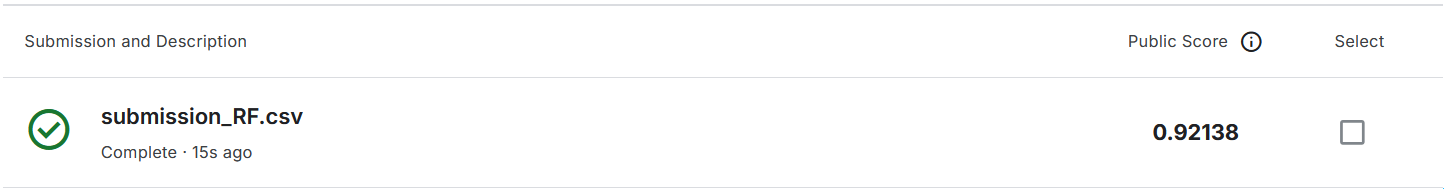

In [22]:
from IPython.core.display import Image, display
display(Image('Kaggle_RF.png', width=900, unconfined=True))